In [2]:

!pip install wordcloud

# Imports lib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
# Load Data (Update file path accordingly)
df = pd.read_csv('/content/amazon.csv.zip')

# Optional: Preview column names
print(df.columns)


Index(['product_id', 'product_name', 'category', 'discounted_price',
       'actual_price', 'discount_percentage', 'rating', 'rating_count',
       'about_product', 'user_id', 'user_name', 'review_id', 'review_title',
       'review_content', 'img_link', 'product_link'],
      dtype='object')


In [6]:
# Convert 'rating' to numeric
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')

# Drop rows where rating is missing or invalid
df = df.dropna(subset=['rating'])
df['rating'] = df['rating'].astype(int)

# Create sentiment from rating
def map_sentiment(rating):
    if rating >= 4:
        return 'Positive'
    elif rating == 3:
        return 'Neutral'
    else:
        return 'Negative'

df['sentiment'] = df['rating'].apply(map_sentiment)


/tmp/ipython-input-6-816326082.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rating'] = df['rating'].astype(int)
/tmp/ipython-input-6-816326082.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment'] = df['rating'].apply(map_sentiment)


In [7]:
#Text cleaning
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'<.*?>', '', text)  # remove HTML
    text = re.sub(r'\d+', '', text)  # remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation))  # remove punctuation
    words = text.split()
    words = [stemmer.stem(word) for word in words if word not in stop_words]
    return ' '.join(words)

df['cleaned_review'] = df['review_content'].apply(clean_text)


/tmp/ipython-input-8-171782084.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=df, palette='Set2')


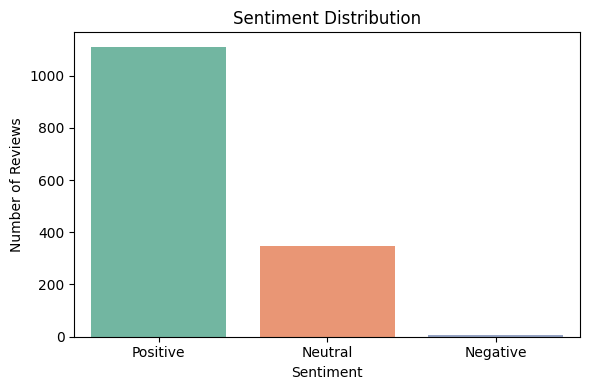

In [8]:
#Sentiment Distribution Plot
plt.figure(figsize=(6, 4))
sns.countplot(x='sentiment', data=df, palette='Set2')
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.tight_layout()
plt.show()




In [10]:
# Feature extraction
tfidf = TfidfVectorizer(max_features=3000)
X = tfidf.fit_transform(df['cleaned_review']).toarray()
y = df['sentiment']


In [11]:
# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Naive Bayes
model = MultinomialNB()
model.fit(X_train, y_train)


MultinomialNB()

In [14]:
model.score(X_train, y_train)

0.7728437233134073

Accuracy: 0.7508532423208191

Classification Report:

              precision    recall  f1-score   support

     Neutral       1.00      0.01      0.03        74
    Positive       0.75      1.00      0.86       219

    accuracy                           0.75       293
   macro avg       0.88      0.51      0.44       293
weighted avg       0.81      0.75      0.65       293



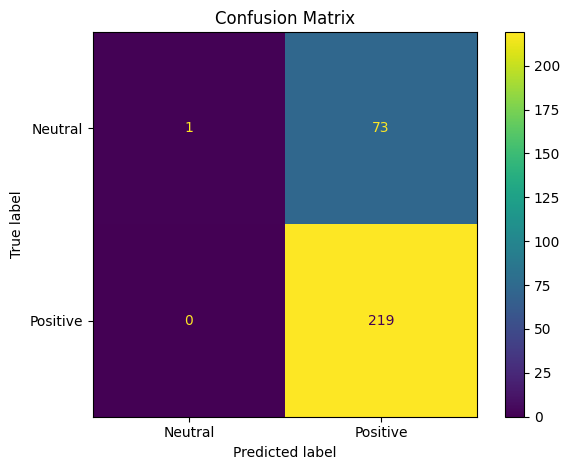

In [12]:
#Predictions
y_pred = model.predict(X_test)

#Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

#Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


In [13]:
#Predict sentiment for new input
def predict_sentiment(text):
    cleaned = clean_text(text)
    vectorized = tfidf.transform([cleaned])
    return model.predict(vectorized)[0]

sample = "This product is really amazing and worth the price!"
print("Review:", sample)
print("Predicted Sentiment:", predict_sentiment(sample))


Review: This product is really amazing and worth the price!
Predicted Sentiment: Positive
